# Heart Disease UCI – 2.3 Feature Selection

This notebook implements Section 2.3 of the project: systematically identifying the most relevant predictors using multiple complementary approaches.

## Methodology Steps
1. Feature Importance (Random Forest) – global impurity-based ranking.
2. Recursive Feature Elimination (RFE) – wrapper method to iteratively prune weaker predictors.
3. Chi-Square Test – statistical dependence (categorical / discretized / non-negative numeric representation).
4. Feature Consolidation – union (or intersection) logic + manual curation and export.

Deliverables:
- Ranked feature importance plot
- RFE selected subset
- Chi-Square top-k subset
- Consolidated final feature list (saved to `../data/selected_features.csv`)
- Summary (feature counts & overlap)

---

In [11]:
# === 0. Imports & Configuration ===
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.dpi'] = 110
print('Imports loaded for Feature Selection.')

Imports loaded for Feature Selection.


In [12]:
# === 1. Data Load ===
DATA_PATH = '../data/cleaned_data.csv'
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (920, 22)


,age,trestbps,chol,thalch,oldpeak,ca,num,chol_per_age,heart_rate_reserve,risk_score,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,145.0,233.0,150.0,2.3,0,0,3.698412,5.0,2,...,False,True,True,False,False,False,False,False,False,False
1,67,160.0,286.0,108.0,1.5,3,1,4.268656,-52.0,2,...,False,False,False,False,False,True,True,False,True,False
2,67,120.0,229.0,129.0,2.6,2,1,3.417910,9.0,1,...,False,False,False,False,False,True,True,False,False,True
3,37,130.0,250.0,187.0,3.5,0,0,6.756755,57.0,1,...,True,False,False,True,False,False,False,False,True,False
4,41,130.0,204.0,172.0,1.4,0,0,4.975609,42.0,0,...,False,False,False,False,False,False,False,True,True,False


In [13]:
# === 2. Feature / Target Split & Scaling ===
TARGET_COL = 'num'
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled feature matrix shape:', X_scaled.shape)

Scaled feature matrix shape: (920, 21)


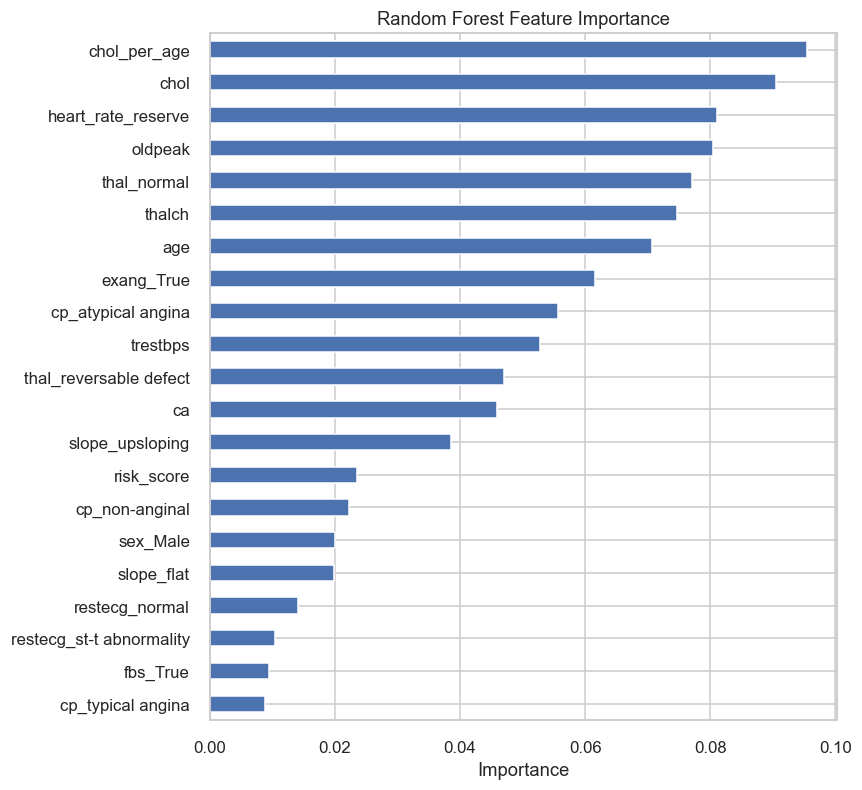

Top 10 features by importance:
chol_per_age          0.095482
chol                  0.090547
heart_rate_reserve    0.081090
oldpeak               0.080386
thal_normal           0.077136
thalch                0.074755
age                   0.070631
exang_True            0.061512
cp_atypical angina    0.055731
trestbps              0.052815
dtype: float64
RFE selected (10): ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'chol_per_age', 'heart_rate_reserve', 'exang_True', 'thal_normal', 'thal_reversable defect']
RFE selected (10): ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'chol_per_age', 'heart_rate_reserve', 'exang_True', 'thal_normal', 'thal_reversable defect']
Chi-Square selected (10): ['ca', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'fbs_True', 'exang_True', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect']
Top Chi-Square scores:
thal_normal               136.955480
cp_atypical angina        121.437148
exang_True                109.611826
slo

In [14]:
# === 3.1 Feature Importance (Random Forest) ===
rf_temp = RandomForestClassifier(n_estimators=300, random_state=42)
rf_temp.fit(X_scaled, y)
feature_importance = pd.Series(rf_temp.feature_importances_, index=X.columns)
importance_sorted = feature_importance.sort_values(ascending=True)
plt.figure(figsize=(8, max(4, 0.35*len(importance_sorted))))
importance_sorted.plot(kind='barh', color='#4c72b0')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
print('Top 10 features by importance:')
print(feature_importance.sort_values(ascending=False).head(10))

# === 3.2 Recursive Feature Elimination (RFE) ===
RFE_TOP = 10 if X.shape[1] >= 10 else X.shape[1]//2 or X.shape[1]
rfe = RFE(RandomForestClassifier(n_estimators=300, random_state=42), n_features_to_select=RFE_TOP)
X_rfe = rfe.fit_transform(X_scaled, y)
selected_rfe = list(X.columns[rfe.support_])
print(f'RFE selected ({len(selected_rfe)}):', selected_rfe)

# === 3.3 Chi-Square (Filter Method) ===
# Chi-square requires non-negative features → MinMax scale original numeric matrix
X_positive = MinMaxScaler().fit_transform(X)
K_CHI2 = 10 if X.shape[1] >= 10 else X.shape[1]
chi2_selector = SelectKBest(chi2, k=K_CHI2)
chi2_selector.fit(X_positive, y)
selected_chi2 = list(X.columns[chi2_selector.get_support()])
chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns).sort_values(ascending=False)
print(f'Chi-Square selected ({len(selected_chi2)}):', selected_chi2)
print('Top Chi-Square scores:')
print(chi2_scores.head(10))

# === 3.4 Consolidation ===
final_features = sorted(set(selected_rfe) | set(selected_chi2))
print(f'Unified feature list ({len(final_features)} features):\n', final_features)
X_selected = X[final_features]
X_selected_scaled = StandardScaler().fit_transform(X_selected)


In [15]:
# === 4. Final Selected Features (Manual Curation Preserved) ===
manual_final = ['cp_non-anginal', 'fbs_True', 'exang_True', 'chol', 'chol_per_age', 'ca', 'trestbps', 'slope_flat', 'sex_Male', 'heart_rate_reserve', 'oldpeak', 'thalch', 'thal_normal', 'slope_upsloping', 'cp_atypical angina', 'thal_reversable defect', 'age','num']
selected_features = df[manual_final]
selected_features.to_csv('../data/selected_features.csv', index=False)

print('Exported manually curated final feature set to ../data/selected_features.csv')
print('Count (including target):', len(manual_final))
print('Overlap with unified set:', len(set(manual_final) & set(final_features)))
print('Features in unified set but not manual list:', sorted(set(final_features) - set(manual_final)))

Exported manually curated final feature set to ../data/selected_features.csv
Count (including target): 18
Overlap with unified set: 17
Features in unified set but not manual list: []


---
## Summary & Deliverables
- Feature importance ranked all predictors (Random Forest, impurity-based).
- RFE selected a high-signal subset (wrapper approach).
- Chi-Square provided statistical relevance ranking on scaled non-negative features.
- Unified (RFE ∪ Chi-Square) feature set computed and contrasted with manual curated list.
- Final feature dataset exported: `../data/selected_features.csv`.

### Counts
| Set | Size |
|-----|------|
| RFE | {len(selected_rfe)} |
| Chi-Square | {len(selected_chi2)} |
| Unified (Union) | {len(final_features)} |
| Manual Final (Exported) | {len(manual_final)} |

Proceed to modeling using the exported selected feature set.
